# Final F: Grasp detection

For your final, you will be developing a grasp detection  that operates on RGB-D sensor data without prior identification of the object.  The simulated robot has an eye-in-hand RGB-D camera, and Klampt can simulate color and depth images that might come from such a sensor.  The purpose of grasp detection is to provide several candidate locations that a gripper might be able to use to grasp observed objects. 

For this grasp detector, you will use the depth readings from the sensor directly to identify useful features that are likely to be graspable. Compared to first identifying the pose of the object and then pre-defining a grasp relative to that pose, this method will allow the robot to grasp a wider variety of objects.  On the other hand, it doesn't make great use of object identity information, if such information were available. (You will find that many non-objects, like the box sides, look very graspable to your detector!)

In [1]:
%load_ext autoreload
%autoreload 2

#these might be useful
from klampt import *
from klampt.math import so3,se3,vectorops
from IPython.display import display,clear_output,Markdown
import time
import ipywidgets as widgets
import ipyklampt
import numpy as np
import math


In [2]:
world = WorldModel()
fn = "data/ur5BlocksSensor.xml"
res = world.readFile(fn)
robot = world.robot(0)

sim = Simulator(world)
controller = sim.controller(0)
camera = controller.sensor('rgbd_camera')

#set the home configuration
qhigh  = robot.getConfig()
qhigh[1] = 2.3562
qhigh[2] = -2*math.pi/3.0
qhigh[3] = math.pi*2.0/3.0
qhigh[4] = 1.36
qhigh[5] = math.pi/2.0
qhigh[6] = 0
robot.setConfig(qhigh)

kvis = ipyklampt.KlamptWidget(world)
display(kvis)
controls = widgets.HBox([])
display(controls)
output_area = widgets.Output()
display(output_area)

S2xhbXB0V2lkZ2V0KHNjZW5lPXt1J29iamVjdCc6IHt1J21hdHJpeCc6IFsxLCAwLCAwLCAwLCAwLCAwLCAtMSwgMCwgMCwgMSwgMCwgMCwgMCwgMCwgMCwgMV0sIHUndXVpZCc6IHUnM2RhZTHigKY=


HBox()

Output()

## Controls

You may change the robot's configuration using the above sliders, and then  update the camera image by running the cell found 2 cells below this one.

In [3]:
from klampt.model import sensing

xform = sensing.get_sensor_xform(camera,robot)

kvis.add_xform("camera",length=0.1)
kvis.set_transform("camera",*xform)

def setConfig(q):
    robot.setConfig(q)
    kvis.set_transform("camera",*sensing.get_sensor_xform(camera,robot))
    kvis.update()

def getImage():
    camera.kinematicSimulate(world,0.01)
    images = sensing.camera_to_images(camera)
    return images


def onChangeConfig(index,q):
    setConfig(q)
    
configWidget = ipyklampt.EditConfig(robot,link_selector='slider',link_subset=[1,2,3,4,5,6],callback=onChangeConfig)
controls.children = (configWidget,)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J0xpbmsnLCBtYXg9NSksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGdldC1pbnRlcmHigKY=


(128, 256, 3)


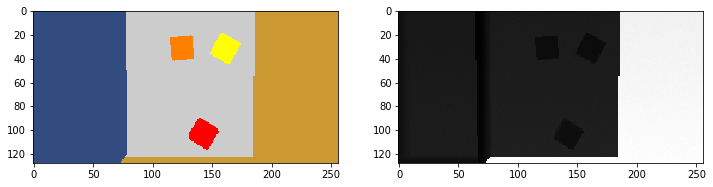

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

#show the images
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

rgb,depth = getImage()

#there might be a problem with the red and blue channels being swapped
rgb = rgb[:,:,::-1]
print rgb.shape
ax1.imshow(rgb)
ax2.imshow(depth,cmap='gist_gray')
plt.show()


In [5]:
setConfig(qhigh)

In [11]:
#get point cloud
pc = sensing.camera_to_points(camera)
print "Converted to point cloud with",pc.shape,"points"
#columns are in the format x,y,z,r,g,b

import random

#corrupt the synthesized point cloud
dstd = 0.01  #approximately 1% error, which is fairly normal for depth sensors
for i in range(pc.shape[0]):
    x,y,z = pc[i][:3]
    znew = random.gauss(z,dstd*z)
    x = x*znew/z
    y = y*znew/z
    pc[i][:3] = [x,y,znew]

world2 = WorldModel()
kvis_pc = ipyklampt.KlamptWidget(world2)
display(Markdown("## Point cloud visualization \n(Note that the X,Y,Z coordinates of the raw point cloud are flipped for better visualization)"))
display(kvis_pc)

Converted to point cloud with (32768, 6) points


## Point cloud visualization 
(Note that the X,Y,Z coordinates of the raw point cloud are flipped for better visualization)

S2xhbXB0V2lkZ2V0KHNjZW5lPXt1J29iamVjdCc6IHt1J21hdHJpeCc6IFsxLCAwLCAwLCAwLCAwLCAwLCAtMSwgMCwgMCwgMSwgMCwgMCwgMCwgMCwgMCwgMV0sIHUndXVpZCc6IHUnZmNiZDXigKY=


In [12]:
#update the above visualization with the point cloud

subsample = 53
kvis_pc.clear_extras()
kvis_pc.begin_rpc(strict=False)
for i in range(pc.shape[0]):
    if i % subsample != 0: continue
    x,y,z,r,g,b = pc[i]
    #show it pointing down, for better visualization
    kvis_pc.add_sphere("p"+str(i),-x,-y,-z,r=0.01)
    kvis_pc.set_color("p"+str(i),r,g,b)
kvis_pc.end_rpc(strict=False)

(1739, 4)
(25, 3)
(20, 4)


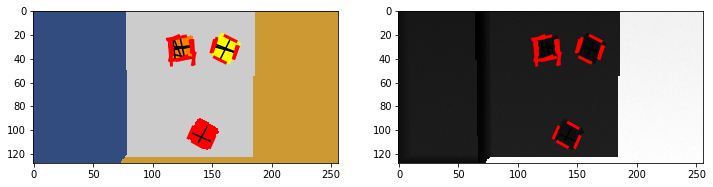

In [14]:
import random

def findGrasp(rgb,depth,pc,N):
    """TODO: find up to N grasping locations in the RGB-D image.  The color (rgb), depth, and point cloud (pc)
    are provided as Numpy arrays.
    
    Return value is a list of up to N tuples (x,y,theta,width) where:
    - x,y are pixel positions in the depth image
    - theta is an orientation of the gripper, in radians, with 0 having the grasping surfaces parallel to the x axis
    - width is a opening width in terms of image pixel size
    """
    # image dimensions (128,256)
    depthList = np.zeros(shape=(128,256,2))
    gradientList = np.zeros(shape=(128,256,2))
    delta = 1
    for i in range(depth.shape[0]):
        for j in range(depth.shape[1]): 
            # using central difference
            if j+1 <= depth.shape[1]-1 and j-1 >= 0:
                depthList[i][j][0] = (depth[i][j+1]-depth[i][j-1])/2
            if i+1 <= depth.shape[0]-1 and i-1 >= 0:
                depthList[i][j][1] = (depth[i-1][j]-depth[i+1][j])/2
            gradientList[i][j][0] = math.sqrt(depthList[i][j][0]**2+depthList[i][j][1]**2)
            gradientList[i][j][1] = math.atan2(depthList[i][j][1],depthList[i][j][0])
    return getGraspList(depthList,gradientList,rgb,depth,pc,N)

def getGraspList(depthList,gradientList,rgb,depth,pc,N):
    graspList = []
    pointList = []
    #width = gripper_max(rgb,depth)
    block_width = 19# determined from gripper_max function which can only accurately execute in qhigh config
    gripperMax = 31 # determined from gripper_max function which can only accurately execute in qhigh config
    for i in range(depth.shape[0]):
        for j in range(depth.shape[1]):
            if gradientList[i][j][0] > 0.015: 
                for d1 in range(-gripperMax,gripperMax): #don't check outside gripper length
                    for d2 in range(-gripperMax,gripperMax):
                        if d1 != 0 and d2 != 0 and math.sqrt(d1**2+d2**2) <= block_width+4 and math.sqrt(d1**2+d2**2) >= block_width-4 and i-d1 >= 0 and i-d1 <= depth.shape[0]-1 and j+d2 <= depth.shape[1]-1 and j+d2 >= 0:
                            magCalc = np.abs(gradientList[i][j][0] - gradientList[i-d1][j+d2][0])
                            thetaCalc = np.abs(gradientList[i][j][1] - gradientList[i-d1][j+d2][1])-math.pi      
                            if magCalc < 0.05 and np.abs(gradientList[i-d1][j+d2][0]) > 0.015 and np.abs(thetaCalc) < 0.2 and checkFlat((i,j),(i-d1,j+d2),depth) and checkColor((int(math.floor((2*i-d1)/2)),int(math.floor((2*j+d2)/2))),rgb): 
                                d = math.sqrt(d1**2+d2**2)
                                theta = (math.pi/2-math.atan2(d1,d2))%math.pi 
                                graspList.append((int(math.floor((2*j+d2)/2)),int(math.floor((2*i-d1)/2)),theta,d))
                                pointList.append((i,j,d1,d2))
    graspList = np.array(graspList)
    pointList = np.array(pointList)
    print(graspList.shape)
    #return graspList
    scoreList = scoreGrasp(graspList,pointList)
    print(scoreList.shape)
    #extraList = []
    #for i in range(scoreList.shape[0]):
    #    extraList.append(scoreList[i][0])
    #return np.array(extraList)
    best = getNBest(scoreList,N)
    print(best.shape)
    return best
                 
    return [(128,64,0,20),(196,64,math.pi/4,25)]
            
def getNBest(sList,N):
    best = []
    firsts = np.amin(np.array([N,6]))
    for n in range(firsts):
        max_val = -1
        pos = -1
        if n >= 1:
            centerX = best[-1][0]
            centerY = best[-1][1]
            theta = best[-1][2]
        for i in range(sList.shape[0]):
            score = sList[i]
            if n == 0 and score[1][0] > max_val:
                max_val = score[1][0]
                pos = i
            elif (n == 1 or n == 3 or n == 5) and score[1][0] > max_val:
                if np.abs(centerX-score[0][0])< 8 and np.abs(centerY-score[0][1])< 8 and np.abs(theta-score[0][2]) > math.pi/2-0.4 and np.abs(theta-score[0][2]) < math.pi/2+0.4:
                    max_val = score[1][0]
                    pos = i
            elif n == 2 and score[1][0] > max_val:
                if np.abs(centerX-score[0][0])> 15 or np.abs(centerY-score[0][1])> 15:
                    max_val = score[1][0]  
                    pos = i
            elif n == 4 and score[1][0] > max_val:
                if (np.abs(centerX-score[0][0])> 15 and np.abs(best[1][0]-score[0][0])> 15) or (np.abs(centerY-score[0][1])> 15 and np.abs(best[1][1]-score[0][1])> 15):
                    max_val = score[1][0]
                    pos = i
        if (n == 1 or n == 3 or n == 5) and max_val == -1 and pos == -1:
            for i in range(sList.shape[0]):
                score = sList[i]
                if score[1][0] > max_val and np.abs(centerX-score[0][0])< 8 and np.abs(centerY-score[0][1])< 8:
                    max_val = score[1][0]
                    pos = i
        for i in range(sList.shape[0]):
            score = sList[i]
            if score[1][0] == max_val and pos == i:
                best.append(score[0])
                score[1][0] = -1
                break
    if N <= 6:
        return np.array(best)
    loops = N-6
    for n in range(loops):
        max_val = -1
        pos = -1
        for i in range(sList.shape[0]):
            score = sList[i]
            if score[1][0] > max_val:
                max_val = score[1][0]
                pos = i
        for i in range(sList.shape[0]):
            score = sList[i]
            if score[1][0] == max_val and pos == i:
                best.append(score[0])
                score[1][0] = -1
                break
    return np.array(best)
        

def checkColor(a,rgb):
    r = rgb[a[0]][a[1]]
    if r[0] == 255 and (r[1] == 0 or r[1] == 127 or r[1] == 255) and r[2] == 0:
        return True
    return False

def checkFlat(a,b,depth): 
    prev_d = depth[a[0],a[1]]
    t_d1 = np.abs(a[0]-b[0])
    t_d2 = np.abs(a[1]-b[1])
    chances = 0
    if b[0]-a[0] < 0 and b[1]-a[1] > 0:
        for d1 in range(t_d1):
            for d2 in range(t_d2):
                if d1 !=0 and d2 != 0: 
                    dep = depth[a[0]-d1,a[1]+d2]
                    if np.abs(dep-prev_d) > 0.01:
                        if chances == 0:
                            return False
                        else:
                            chances = chances-1
                    prev_d = dep
        return True
    if b[0]-a[0] > 0 and b[1]-a[1] > 0:
        for d1 in range(t_d1):
            for d2 in range(t_d2):
                if d1 !=0 and d2 != 0: 
                    dep = depth[a[0]+d1,a[1]+d2]
                    if np.abs(dep-prev_d) > 0.01:
                        if chances == 0:
                            return False
                        else:
                            chances = chances-1
                    prev_d = dep
        return True
    if b[0]-a[0] > 0 and b[1]-a[1] < 0:
        for d1 in range(t_d1):
            for d2 in range(t_d2):
                if d1 !=0 and d2 != 0: 
                    dep = depth[a[0]+d1,a[1]-d2]
                    if np.abs(dep-prev_d) > 0.01:
                        if chances == 0:
                            return False
                        else:
                            chances = chances-1
                    prev_d = dep
        return True
    if b[0]-a[0] < 0 and b[1]-a[1] < 0:
        for d1 in range(t_d1):
            for d2 in range(t_d2):
                if d1 !=0 and d2 != 0: 
                    dep = depth[a[0]-d1,a[1]-d2]
                    if np.abs(dep-prev_d) > 0.01:
                        if chances == 0:
                            return False
                        else:
                            chances = chances-1
                    prev_d = dep
        return True
    if b[0]-a[0] == 0 and b[1]-a[1] > 0:
        for d2 in range(t_d2):
            if d2 != 0: 
                dep = depth[a[0],a[1]+d2]
                if np.abs(dep-prev_d) > 0.01:
                    if chances == 0:
                        return False
                    else:
                        chances = chances-1
                prev_d = dep
        return True
    if b[0]-a[0] == 0 and b[1]-a[1] < 0:
        for d2 in range(t_d2):
            if d2 != 0: 
                dep = depth[a[0],a[1]-d2]
                if np.abs(dep-prev_d) > 0.01:
                    if chances == 0:
                        return False
                    else:
                        chances = chances-1
                prev_d = dep
        return True
    if b[1]-a[1] == 0 and b[0]-a[0] < 0:
        for d1 in range(t_d1):
            if d1 != 0: 
                dep = depth[a[0]-d1,a[1]]
                if np.abs(dep-prev_d) > 0.01:
                    if chances == 0:
                        return False
                    else:
                        chances = chances-1
                prev_d = dep
        return True
    if b[1]-a[1] == 0 and b[0]-a[0] > 0:
        for d1 in range(t_d1):
            if d1 != 0: 
                dep = depth[a[0]+d1,a[1]]
                if np.abs(dep-prev_d) > 0.01:
                    if chances == 0:
                        return False
                    else:
                        chances = chances-1
                prev_d = dep
        return True
    print("couldn't determine")
    return True

def gripper_max(rgb,depth):
    # config of robot must be at qhigh in order for this to work properly
    prev_r = rgb[40,99]
    prev_d = 0
    count = 0
    for i in range(100,140):
        r = rgb[40,i]
        d = depth[40,i]
        if r[0] != prev_r[0] and r[1] != prev_r[1] and r[2] != prev_r[2] and count == 0:
            block_width = np.abs(d-prev_d)
            count = 1
            pixel = i
        elif r[0] != prev_r[0] and r[1] != prev_r[1] and r[2] != prev_r[2] and count == 1:
            pixel_width = i - pixel
            break
        prev_r = r
        prev_d = d
    factor = pixel_width/block_width
    return [int(math.floor(.1*factor)),int(math.floor(pixel_width))] # since max gripper length is 10cm or 0.1m

def scoreGrasp(gList,pList):
    scoreList = []
    counts = np.zeros(shape=(gList.shape[0],9)) 
    for i in range(counts.shape[0]):
        counts[i][1] = 300
        counts[i][2] = 300
        counts[i][5] = 300
        counts[i][6] = 300
    for i in range(gList.shape[0]):
        for j in range(gList.shape[0]):
            if i != j:
                grasp1 = gList[i]
                grasp2 = gList[j]
                if np.abs(grasp1[2]%math.pi-grasp2[2]%math.pi)<=0.5:
                    if np.abs(grasp1[3]-grasp2[3]) < 8: 
                        g1i, g1j, g1d1, g1d2 = pList[i]
                        g2i, g2j, g2d1, g2d2 = pList[j] 
                        g1otheri = g1i-g1d1
                        g1otherj = g1j+g1d2
                        g2otheri = g2i-g2d1
                        g2otherj = g2j+g2d2
                        if np.abs(g1i-g2i) < 8 and np.abs(g1j-g2j) < 8 and np.abs(g1otheri-g2otheri) < 8 and np.abs(g1otherj-g2otherj) < 8:
                            counts[i][0] = counts[i][0] + 1
                            if counts[i][1] > g2i: #get minimum x
                                counts[i][1] = g2i
                            if counts[i][2] > g2j: # get minimum y
                                counts[i][2] = g2j
                            if counts[i][3] < g2i: # save maximum x
                                counts[i][3] = g2i
                            if counts[i][4] < g2j: # save maximum y
                                counts[i][4] = g2j
                            if counts[i][5] > g2otheri: #get minimum x other
                                counts[i][5] = g2otheri
                            if counts[i][6] > g2otherj: # get minimum y other
                                counts[i][6] = g2otherj
                            if counts[i][7] < g2otheri: # save maximum x other
                                counts[i][7] = g2otheri
                            if counts[i][8] < g2otherj: # save maximum y other
                                counts[i][8] = g2otherj
    for i in range(counts.shape[0]):
        if counts[i][0] == 0: # must be unique
            scoreList.append([gList[i],counts[i],pList[i]])
        else:
            c1 = counts[i]
            p = pList[i]
            if len(scoreList) == 0 or not isInScoreList(c1,scoreList,p):
                scoreList.append([gList[i],c1,p])
    scoreList = np.array(scoreList)  
    return scoreList      

def checkCounts(counts,gList):
    for i in range(counts.shape[0]):
        if counts[i][0] == 0:
            print((0,gList[i]))            

def isInScoreList(count,scoreList,p):
    for i in range(len(scoreList)):
        score = scoreList[i][1]    #np.abs(count[5]-score[5])>1.8 and # need to fine tune these so that returns closest ones, so if vertical, make sure vertical component difference is small, had 10 before
        if sameOrBasicallySame(scoreList[i][2],p) or (np.abs(count[1]-score[1])<10 and np.abs(count[2]-score[2])<10 and np.abs(count[3]-score[3])<10 and np.abs(count[4]-score[4])<10 and np.abs(count[5]-score[5])<10 and np.abs(count[6]-score[6])<10 and np.abs(count[7]-score[7])<10 and np.abs(count[8]-score[8])<10):
            if count[0] > score[0]: 
                del scoreList[i]
                return False
            else:
                return True
    return False

def sameOrBasicallySame(score,p):
    si, sj, sd1, sd2 = score
    pi, pj, pd1, pd2 = p
    potheri = pi-pd1 
    potherj = pj+pd2
    sotheri = si-sd1
    sotherj = sj+sd2
    if (np.abs(pi-si)<5 and np.abs(pj-sj)<5 and np.abs(potheri-sotheri)<5 and np.abs(potherj-sotherj)<5) or (np.abs(pi-sotheri)<5 and np.abs(pj-sotherj)<5 and np.abs(potheri-si)<5 and np.abs(potherj-sj)<5):
        return True
    return False
    
grasps = findGrasp(rgb,depth,pc,)

#show the images
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(rgb)
ax2.imshow(depth,cmap='gist_gray')
for g in grasps:
    x,y,theta,width = g
    c,s = math.cos(theta),math.sin(theta)
    gopen = width
    glen = width*0.5
    R = np.array([[c,-s],[s,c]])
    p1 = (0,-gopen*0.5)
    p2 = (0,gopen*0.5)
    p1a = (-glen*0.5,-gopen*0.5)
    p1b = (glen*0.5,-gopen*0.5)
    p2a = (-glen*0.5,gopen*0.5)
    p2b = (glen*0.5,gopen*0.5)
    center = np.array([x,y])
    p1 = np.dot(R,p1) + center
    p2 = np.dot(R,p2) + center
    p1a = np.dot(R,p1a) + center
    p1b = np.dot(R,p1b) + center
    p2a = np.dot(R,p2a) + center
    p2b = np.dot(R,p2b) + center
    #ax1.plot(x,y,'go')
    ax1.plot([p1a[0],p1b[0]],[p1a[1],p1b[1]],color='r',lw='3',zorder=4)
    ax1.plot([p2a[0],p2b[0]],[p2a[1],p2b[1]],color='r',lw='3',zorder=4)
    ax1.plot([p1[0],p2[0]],[p1[1],p2[1]],color='k',zorder=2)
    ax2.plot([p1a[0],p1b[0]],[p1a[1],p1b[1]],color='r',lw='3',zorder=4)
    ax2.plot([p2a[0],p2b[0]],[p2a[1],p2b[1]],color='r',lw='3',zorder=4)
    ax2.plot([p1[0],p2[0]],[p1[1],p2[1]],color='k',zorder=2)
plt.show()

# for some reason qhigh configuration sometimes gives weird results, 
# most other configurations that are about the same height above blocks as qhigh
# should be able to return reasonable results 
# NOTE: Running All Cells will often produce different grasps

For each detected grasp, the gripper jaws are drawn in red, and the closure direction is drawn in black.

Right now the provided code doesn't even look into the sensor information.

## Assignment

Your job is to implement findGrasp so that it produces reasonable estimates of "graspable" elements in your image.  A graspable object is one where two nearly parallel walls, nearly perpendicular to the camera, are sufficiently close to one another to be grasped.  The definition of "nearly" should depend on some parameters that you define, and "sufficiently close" should depend on the gripper's maximum width (approximately 10cm).

Your strategy might, for example, consider the gradient of the depth image.  A reasonable candidate for a grasp would be two nearby points (within the gripper's maximum width) that have nearly opposite and strong gradients, with the gradient pointing almost directly toward the other point.  You would also like to make sure that the depths in between those points do not vary too much, since this would correspond to a flat surface.  It is recommended that you define a grasp scoring function, choose a wide variety of grasps using some sort of sampling, and return the N best grasps.

(You should probably see that the procedure returns candidate grasps around the blue box sides, because these are parallel and close to each other.  This is perfectly normal.)

In your report, precisely and in technical English language (not code, although pseudocode may be acceptable), describe your strategy for generating these planes.  This should include, but is not limited to:

* How do you judge the quality of a candidate grasp?  What parameters, such as weights, are used by this estimate? 

* Analyze how certain your scoring function correlates with the physical 3D geometry of a gripper and a potential object to grasp.

* How do you generate grasp candidates?  What parameters, such as the number of samples, or resolution of a grid, are used by this procedure?

* The results are returned in image coordinates.  What potential challenges does this pose for a user (e.g., a person working on motion planning) when interpreting your results?

## Unit testing

Perform unit testing of your plane extractor, and describe the performance metrics and test procedure that you are using.  Interpret the observations you have made, including but not limited to:

* Whether performance is sensitive to certain parameters.
* Whether performance limitations or bottlenecks can be identified.
* Whether unit tests agree with theoretical behavior.

If you had access to a physical system for testing grasps, how would your performance metrics and test procedure change?  How would you be able to use data from testing to improve your grasp detector?